In [652]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D

from wiring_efficiency_utils import *
from neuralsheet import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
# Example usage
crop_size = 32  # Crop size (NxN)
batch_size = 32  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './imagenet_mini'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
M = 64 # Neural sheet dimensions
std_e = 1 # Standard deviation for excitation Gaussian
epochs = 15

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
model = NeuralSheet(M, crop_size, std_e, device=device).to(device)

In [1196]:
# Looping over the DataLoader

lr = 1e-4

for e in range(epochs):
    
    #decay = 1.6
    #lr = lr/decay if lr/decay>1e-4 else 1e-4
    
    batch_progress = tqdm(dataloader, leave=False)
    for batch in batch_progress:
        batch = batch.to('cuda')  # Transfer the entire batch to GPU
        for image in batch:
            
            if image.mean()>0.15:
                                
                model(image[None])
                model.hebbian_step(lr)
            
        mean_activation = model.mean_activations.mean()
        batch_progress.set_description('Mean acts: {:.3f}'.format(mean_activation))
        

KeyboardInterrupt: 

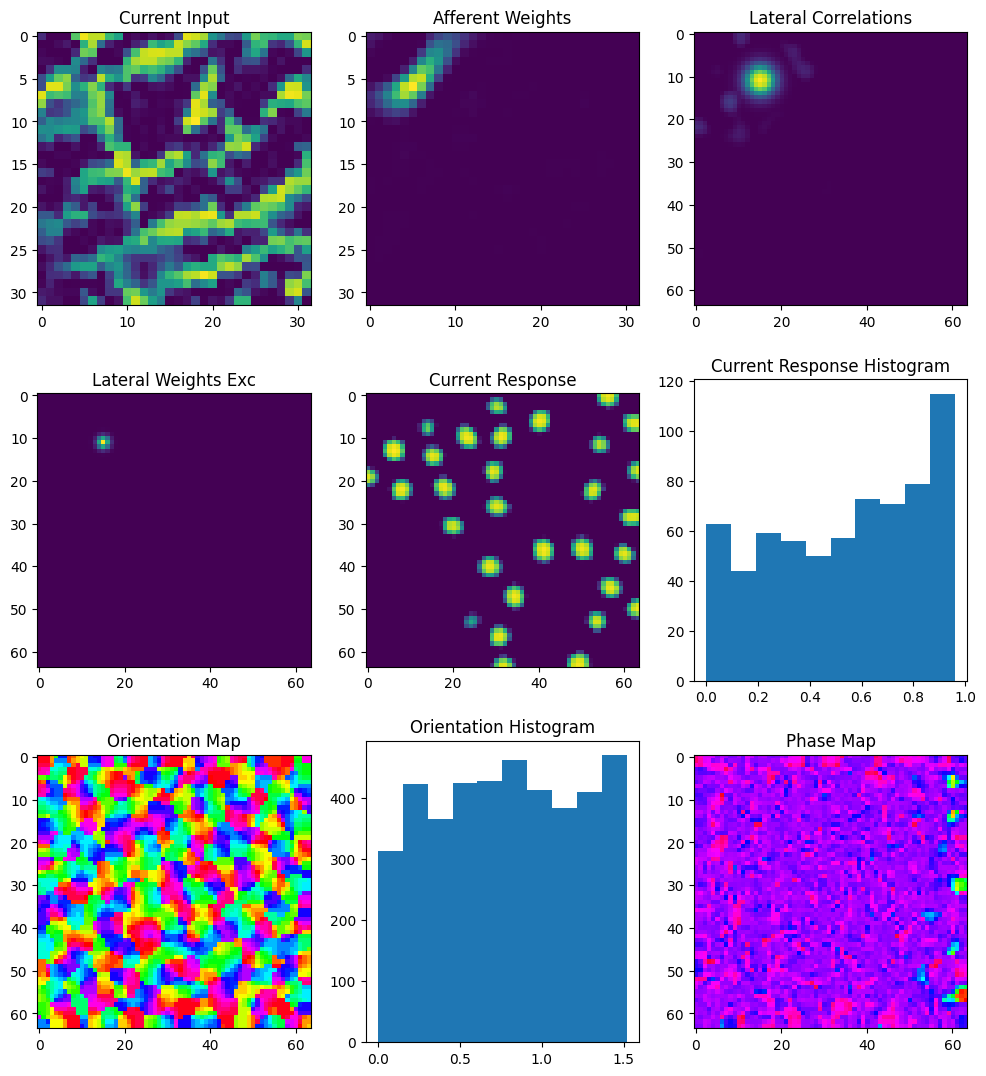

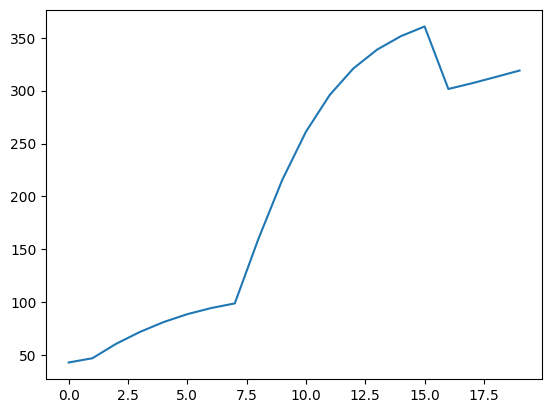

In [1203]:
%matplotlib inline
show_map(model, batch)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)
plt.plot(model.response_tracker.sum([1,2,3]).cpu())
anim

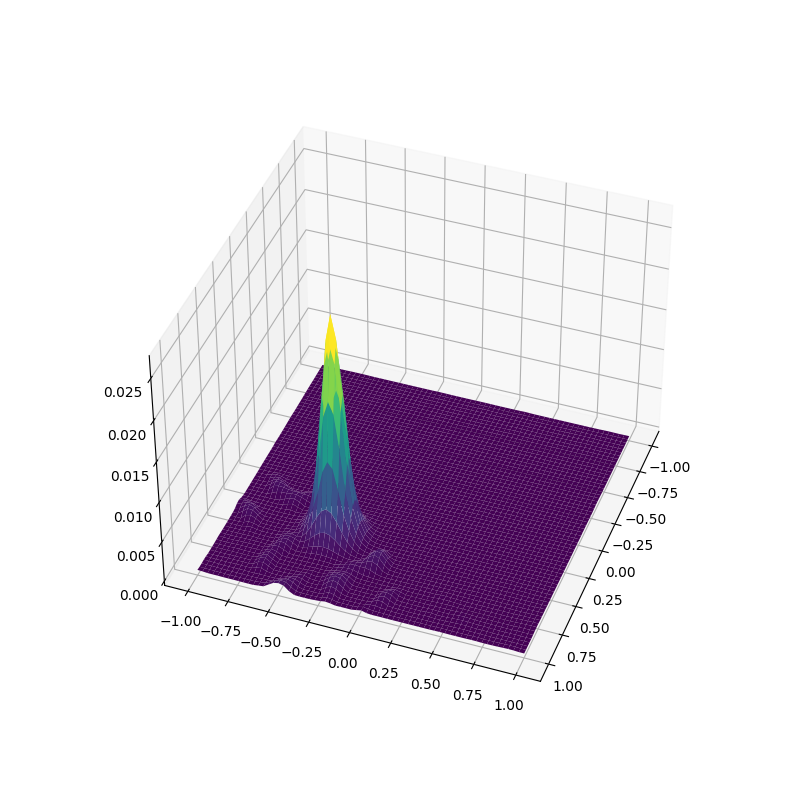

In [1234]:
%matplotlib widget
sample = np.random.randint(0, model.sheet_size**2)
x = np.linspace(-1, 1, M)
y = np.linspace(-1, 1, M)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu()
z = z*model.eq + model.untuned_inh[sample,0].cpu()*(1-model.eq)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# Change the perspective
elev = 40  # Use a positive value to raise the perspective
azim = 20  # Use a positive value to rotate the plot anticlockwise
ax.view_init(elev=elev, azim=azim)


ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', rstride=1, cstride=1, alpha=1)
plt.show()

/tmp/ipykernel_6720/2809896336.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_tensor = torch.tensor(distribution.flatten(), dtype=torch.float)


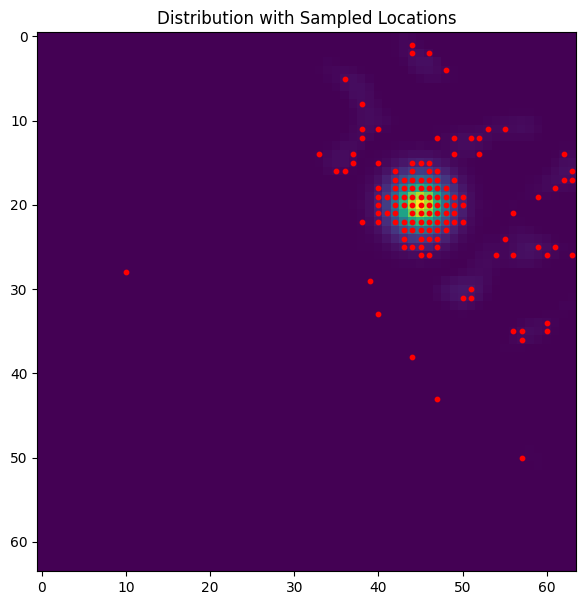

In [1235]:
%matplotlib inline

S = 130   # Number of samples you want to draw
theta = 0

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

# Convert distribution to PyTorch tensor and flatten for sampling
dist_tensor = torch.tensor(distribution.flatten(), dtype=torch.float)

# Sample S locations from the distribution
indices = torch.multinomial(dist_tensor, S, replacement=False)

# Convert flat indices back to 2D indices
y, x = np.unravel_index(indices.numpy(), (M, M))

# Visualization with Matplotlib
plt.figure(figsize=(7,7))
plt.imshow(distribution, cmap='viridis', interpolation='nearest')
plt.scatter(x, y, color='r', s=10)  # s is the size of points
plt.title('Distribution with Sampled Locations')
plt.show()

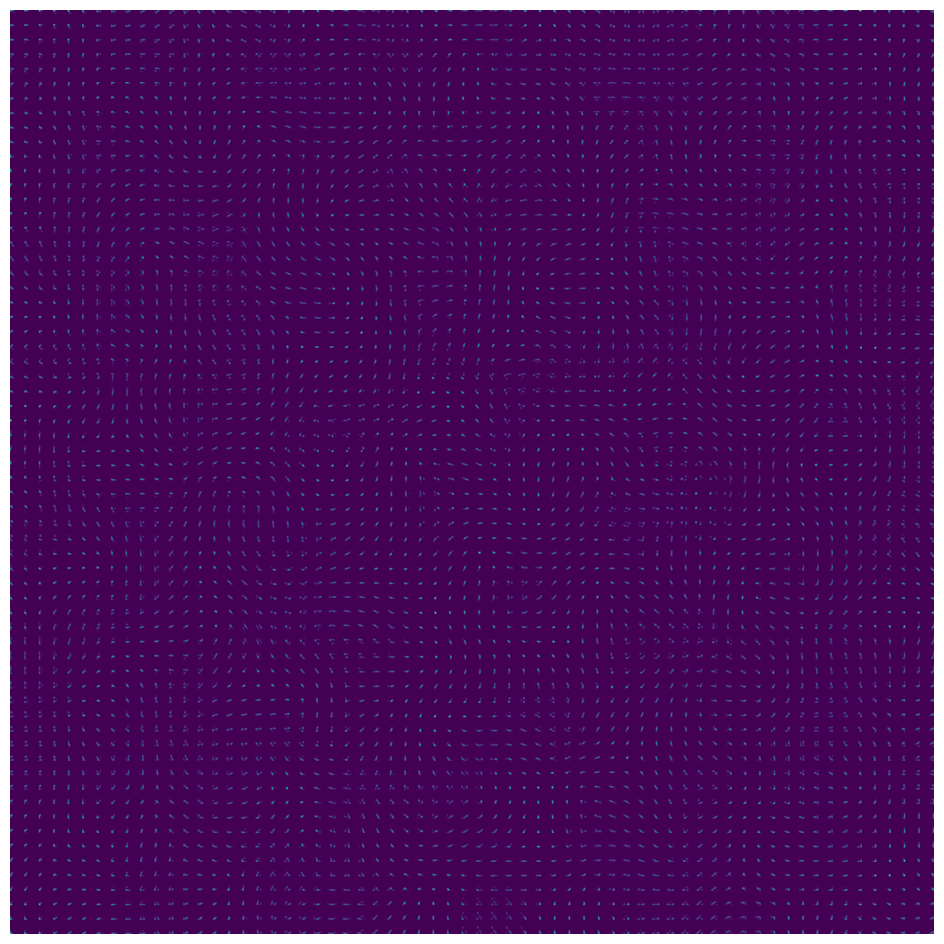

In [1236]:
%matplotlib inline
angles = model.afferent_weights.cpu()
angles = angles[:,0].view(M, M, crop_size, crop_size)
angles = angles.permute(0,2,1,3).reshape(M*crop_size, M*crop_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)